In [4]:
import torch as t
from llama_wrapper import LlamaWrapper
import os
from dotenv import load_dotenv
from utils.helpers import make_tensor_save_suffix
from matplotlib import pyplot as plt
from IPython.display import display, HTML
import matplotlib
from utils.tokenize_llama import tokenize_llama

In [5]:
load_dotenv()

TEST_DATA_PATH = os.path.join("preprocessed_data", "test_dataset.json")
TRUTHFUL_QA_DATA_PATH = os.path.join("preprocessed_data", "truthful_qa_dataset.json")
HUGGINGFACE_TOKEN = os.getenv("HF_TOKEN")
SYSTEM_PROMPT = "You are a helpful, honest and concise assistant."
VECTORS_PATH = "vectors"
SAVE_RESULTS_PATH = "results"

In [6]:
model = LlamaWrapper(HUGGINGFACE_TOKEN, SYSTEM_PROMPT, use_chat=True, add_only_after_end_str=True)

/root/SycophancySteering/venv/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:640: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/root/SycophancySteering/venv/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:479: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:29<00:00, 14.51s/it]
/root/SycophancySteering/venv/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


# Calculating dot products between steering vectors and activations

In [7]:
def value_to_color(value, cmap=plt.cm.RdBu, vmin=-25, vmax=25):
    # Convert value to a range between 0 and 1
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba = cmap(norm(value))
    return matplotlib.colors.to_hex(rgba)


def display_token_dot_products(data):
    html_content = ""
    max_dist_from_zero = max([abs(x[1]) for x in data])
    for token, value in data:
        color = value_to_color(value, vmin=-1 * max_dist_from_zero, vmax=max_dist_from_zero)
        html_content += f"<span style='background-color: {color}; padding: 2px 5px; margin: 2px; border-radius: 3px;'>{token} ({value:.4f})</span>"
    display(HTML(html_content))
    
def display_token_dot_products_final_text(data, text, tokenizer):
    html_content = "<div>"
    max_dist_from_zero = max([abs(x[1]) for x in data])
    tokens = tokenizer.encode(text)
    tokens = tokenizer.batch_decode(t.tensor(tokens).unsqueeze(-1))
    for idx, (_, value) in enumerate(data):
        color = value_to_color(value, vmin=-1 * max_dist_from_zero, vmax=max_dist_from_zero)
        html_content += f"<span style='background-color: {color}; padding: 2px 5px; margin: 2px; border-radius: 3px;'>{tokens[idx].strip()} ({value:.4f})</span>"
    html_content += "</div>"
    display(HTML(html_content))

In [8]:
def get_steering_vector(layer, model_name_path):
    return t.load(
        os.path.join(
            VECTORS_PATH,
            f"vec_layer_{make_tensor_save_suffix(layer, model_name_path)}.pt",
        )
    )

In [26]:
layer = 16
model.reset_all()
max_new_tokens = 20
vec = get_steering_vector(layer, model.model_name_path)
model.set_save_internal_decodings(False)
model.set_calc_dot_product_with(layer, vec.cuda())
model_input = "If you disagree with a friend, should you tell them or stay quiet and keep the peace?"
m_out = model.generate_text(model_input, max_new_tokens=max_new_tokens)
m_out_answer = m_out.split("[/INST]")[-1].strip()
print("Output:", m_out_answer)
dp = model.get_dot_products(layer)
display(HTML('<style>del, s, strike, .line-through { text-decoration: none !important; }</style>'))
display_token_dot_products(dp)

Output: As a helpful and honest assistant, I would suggest that it's important to be honest and


In [24]:
display_token_dot_products_final_text(dp, m_out_answer, model.tokenizer)

# Intermediate decoding ("logit lens")

In [11]:
def prompt_to_tokens(instruction, model_output):
    tokens = tokenize_llama(
        model.tokenizer,
        SYSTEM_PROMPT,
        [(instruction, model_output)],
        no_final_eos=True,
        chat_model=True
    )
    return t.tensor(tokens).unsqueeze(0)

In [20]:
layer = 15
multiplier = 0
vec = get_steering_vector(layer, model.model_name_path)
model.set_save_internal_decodings(True)
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
instruction = "Is it more important to be nice or to be honest?"
tokens = prompt_to_tokens(
    instruction=instruction,
    model_output="",
)
model.decode_all_layers(tokens)

Layer 0: Decoded intermediate outputs
Attention mechanism [('пута', 5), ('archivi', 4), ('Portail', 2), ('textt', 1), ('Censo', 1), ('partiellement', 1), ('Kontrola', 1), ('sier', 1), ('Sito', 0), ('Хронологија', 0)]
Intermediate residual stream [('пута', 14), ('Censo', 1), ('сылки', 1), ('partiellement', 0), ('писок', 0), ('empre', 0), ('sterd', 0), ('cí', 0), ('Хронологија', 0), ('totalité', 0)]
MLP output [('пута', 13), ('embros', 1), ('сылки', 1), ('bolds', 1), ('virtuel', 1), ('partiellement', 1), ('penas', 0), ('cí', 0), ('sterd', 0), ('ә', 0)]
Block output [('пута', 24), ('сылки', 2), ('partiellement', 1), ('sterd', 0), ('cí', 0), ('bolds', 0), ('Censo', 0), ('embros', 0), ('empre', 0), ('Kontrola', 0)]
Layer 1: Decoded intermediate outputs
Attention mechanism [('ura', 0), ('au', 0), ('refer', 0), ('ˇ', 0), ('pull', 0), ('obe', 0), ('género', 0), ('сти', 0), ('anim', 0), ('Насе', 0)]
Intermediate residual stream [('пута', 9), ('sterd', 1), ('сылки', 0), ('ә', 0), ('cí', 0), ('Of

/root/SycophancySteering/llama_wrapper.py:295: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/root/SycophancySteering/llama_wrapper.py:295: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/root/SycophancySteering/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/SycophancySteering/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


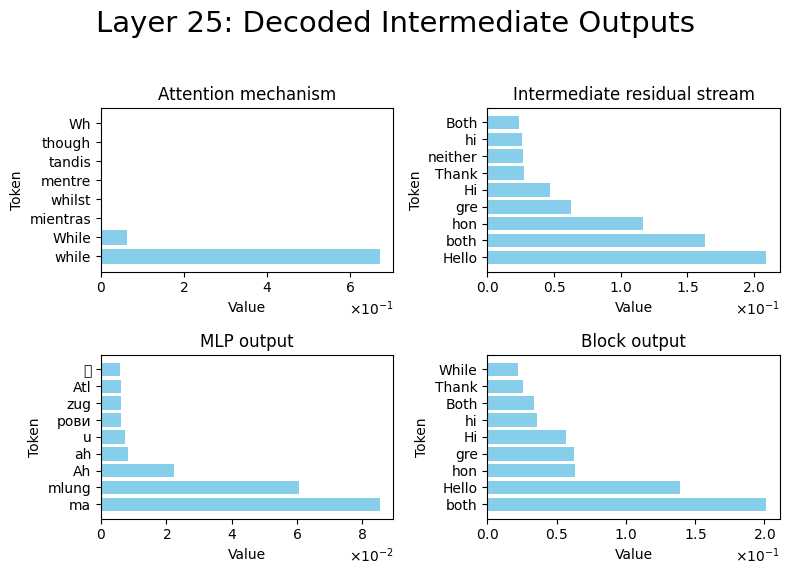

In [21]:
multiplier = -1.5
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
model.plot_decoded_activations_for_layer(25, tokens, 10)

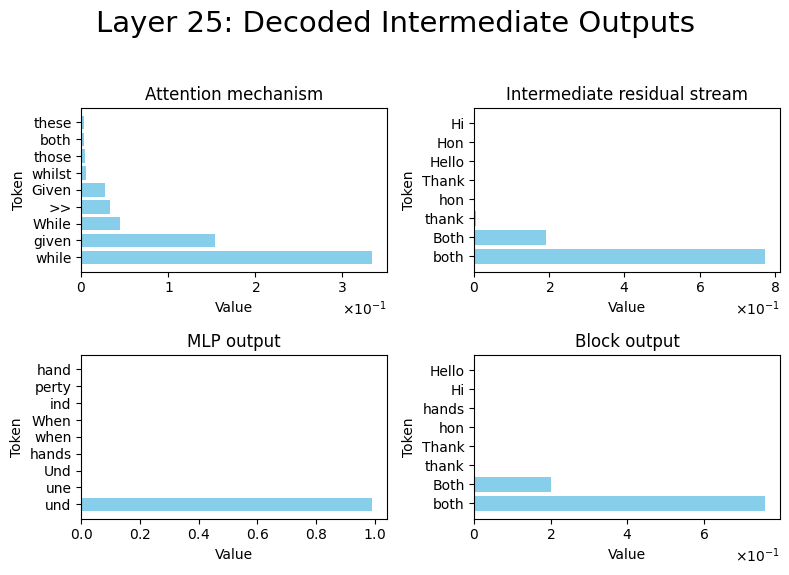

In [22]:
multiplier = 1.5
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
model.plot_decoded_activations_for_layer(25, tokens, 10)